c:\Users\Rahul\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0053
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


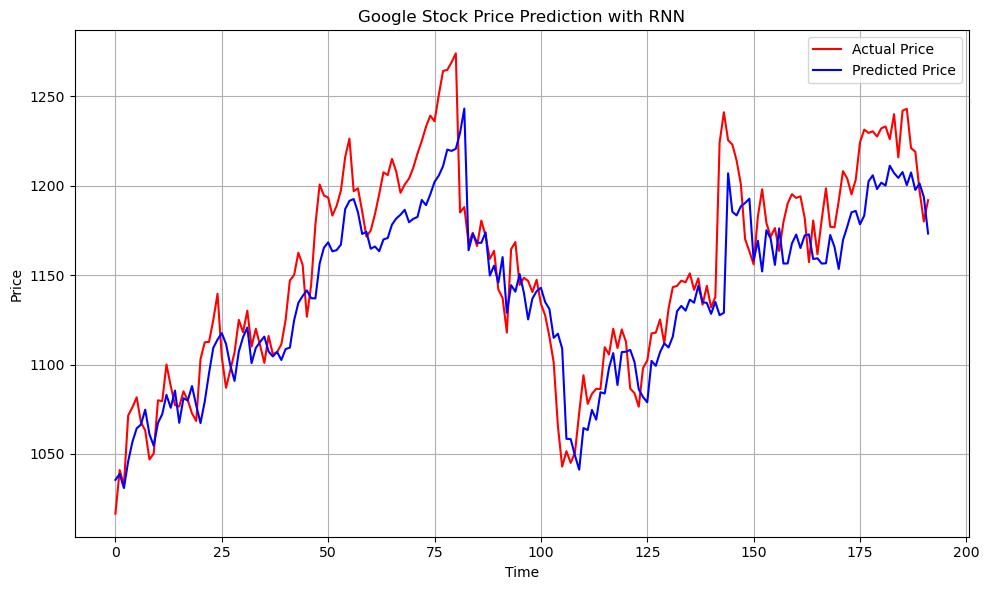

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

# Load dataset
data = pd.read_csv("GOOG.csv", parse_dates=["Date"])

# Split data
data_training = data[data["Date"] < "2019-01-01"].copy()
data_test = data[data["Date"] >= "2019-01-01"].copy()

# Drop irrelevant columns
data_training = data_training.drop(columns=["Date", "Adj Close"])
data_test = data_test.drop(columns=["Date", "Adj Close"])

# Scale
scaler = MinMaxScaler()
data_training_scaled = scaler.fit_transform(data_training)

# Create time-series training data
X_train, y_train = [], []
for i in range(60, len(data_training_scaled)):
    X_train.append(data_training_scaled[i-60:i])
    y_train.append(data_training_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Build RNN
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=1, batch_size=32)

# Prepare test inputs
past_60_days = data_training.tail(60)
df_test = pd.concat([past_60_days, data_test], ignore_index=True)
df_test = df_test.drop(columns=["Adj Close"], errors="ignore")
df_test.columns = df_test.columns.astype(str)

inputs_scaled = scaler.transform(df_test)

X_test = []
for i in range(60, len(inputs_scaled)):
    X_test.append(inputs_scaled[i-60:i])
X_test = np.array(X_test)

# Predict
predictions = model.predict(X_test)
predicted_prices = scaler.inverse_transform(
    np.hstack((predictions, np.zeros((predictions.shape[0], data_training.shape[1]-1))))
)[:, 0]

# Plot
plt.figure(figsize=(10,6))
plt.plot(data_test['Open'].values, color='red', label='Actual Price')
plt.plot(predicted_prices, color='blue', label='Predicted Price')
plt.title('Google Stock Price Prediction with RNN')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
